In [2]:
import typing
import colorgram
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

우선 파일을 불러오자.

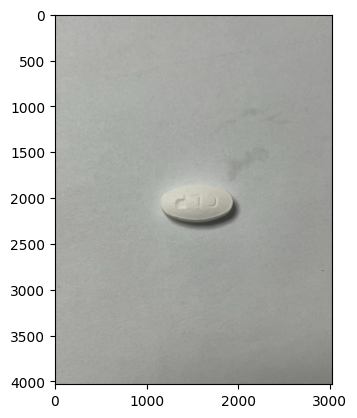

In [4]:
image = cv2.imread('/Users/hepheir/Downloads/IMG_9652.png')
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_image)

이 파일에서 어떻게 하면 알약을 찾을 수 있을 지, 알아보자.

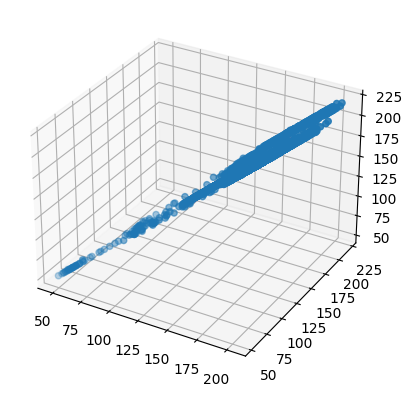

In [5]:
img = cv2.resize(image, (128, 128))
colors = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(colors[:,0], colors[:,1], colors[:,2], marker='o')

In [9]:
def extract_colors(frame: np.ndarray, number_of_colors:int=6) -> typing.List[colorgram.Color]:
    down_sample_dst_size = (64, 64)
    down_sampled_frame = cv2.resize(frame, down_sample_dst_size)
    pil_image = Image.fromarray(down_sampled_frame)
    return colorgram.extract(pil_image, number_of_colors)


def make_pallete(colors: typing.List[colorgram.Color]) -> np.ndarray:
    size = 64
    frame = np.zeros((size, size * len(colors), 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        frame[:, size*i:size*(i+1)] = color.rgb
    return frame


def freq_2d_filter(gray: np.ndarray, filter: np.ndarray) -> np.ndarray:
    if len(gray.shape) != 2:
        raise ValueError()
    fft = np.fft.fft2(np.float32(gray))
    fft_shift = np.fft.fftshift(fft)
    fft_ishift = np.fft.ifftshift(fft_shift * filter)
    ifft = np.fft.ifft2(fft_ishift)
    return np.uint8(cv2.magnitude(ifft.real, ifft.imag))


def gaussian_2d_filter(shape: typing.Tuple[int], radius: int) -> np.ndarray:
    h, w = shape[:2]
    cy, cx = h/2, w/2
    X, Y = np.meshgrid(np.linspace(1, w, w), np.linspace(1, h, h))
    out = np.exp(-(np.power(X-cx,2)+np.power(Y-cy,2))/(2*np.power(radius,2)))
    return out

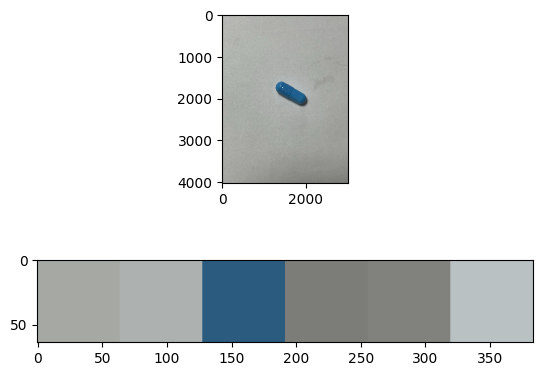

In [ ]:
colors = extract_colors(image)

plt.subplot(211)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(212)
plt.imshow(cv2.cvtColor(make_pallete(colors), cv2.COLOR_BGR2RGB))
plt.show()

1


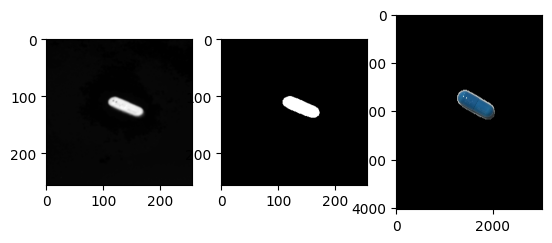

In [ ]:
gray = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))[1]

gray_ds = cv2.resize(gray, (256, 256))
gray_ds = cv2.GaussianBlur(gray_ds, (5,5), 1)

bin = cv2.threshold(gray_ds, 25, 255, cv2.THRESH_BINARY)[1]

contours = cv2.findContours(bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
print(len(contours))

mask = np.zeros_like(gray_ds)
cv2.drawContours(mask, contours, -1, 255, -1)
mask = cv2.resize(mask, image.shape[1::-1])

bg_removed = cv2.copyTo(image, mask)

plt.subplot(131)
plt.imshow(gray_ds, cmap='gray')
plt.subplot(132)
plt.imshow(bin, cmap='gray')
plt.subplot(133)
plt.imshow(cv2.cvtColor(bg_removed, cv2.COLOR_BGR2RGB))
plt.show()

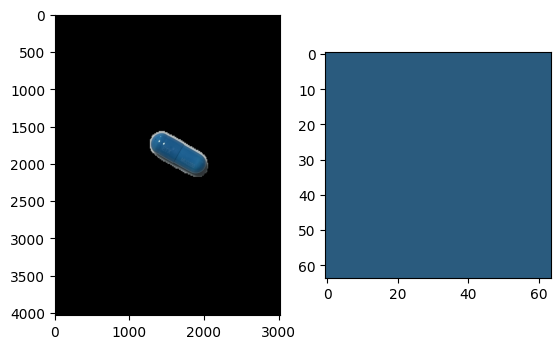

In [ ]:
primary_color = extract_colors(bg_removed, 2)[1]
pallete = make_pallete([primary_color])

plt.subplot(121)
plt.imshow(cv2.cvtColor(bg_removed, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(pallete, cv2.COLOR_BGR2RGB))